# Section 2.3

## Dataset creation
Created by randomly refining edges in a uniform triangular mesh for $8\times 8, 16\times 16, 32 \times 32$ and $64\times 64$ cells that are split into $2$ triangles as many times, so that no mesh is finer than the $64\times 64$ mesh.

```Python
from dolfinx import mesh as msh
from dolfinx import io
import torch
from mpi4py import MPI
import numpy as np

rng = np.random.default_rng()

def mesh_to_x(mesh, bK, device=None, dtype=None):
    lst = []
    for v in mesh.geometry.x[:,0:2][mesh.geometry.dofmap]:
        xK = np.concat((v[2]-v[1], v[2]-v[0], v[1]-v[0], bK), axis=None)
        lst.append(xK)

    xnp=np.array(lst).T
    return torch.tensor(xnp, requires_grad=False, device=device, dtype=dtype)

bK = np.array([1,0])

num = 0
# base meshes
for s in range(4):
    domain = msh.create_unit_square(MPI.COMM_WORLD, int(2**(s+2)), int(2**(s+2)), msh.CellType.triangle)
    with io.XDMFFile(domain.comm, f"data/example_2_1/training_set/fem_data/mesh_{num}.xdmf", "w") as writer:
        writer.write_mesh(domain)
    x = mesh_to_x(domain, bK)
    torch.save(x, f'data/example_2_1/training_set/inputs/x_{num}.pt')
    num += 1

for j in range(10): #sample 10 times overall
    for i in range(1,8): #iterate through 1/8, 2/8,..., 7/8 of al edges in the current mesh 
        for s in range(3): #iterate through 4 by 4, 8 by 8, 16 by 16 base-mesh
            domain = msh.create_unit_square(MPI.COMM_WORLD, int(2**(s+2)), int(2**(s+2)), msh.CellType.triangle)
            for k in range(3-s): #refine so that no edge is smaller than in a 32 by 32 mesh
                domain.topology.create_entities(1)
                N = domain.topology.index_map(1).size_local
                edges = rng.choice(N, size=int(N*i/8), replace=False)
                domain = msh.refine(domain, edges)[0]
                with io.XDMFFile(domain.comm, f"data/example_2_1/training_set/fem_data/mesh_{num}.xdmf", "w") as writer:
                    writer.write_mesh(domain)
                x = mesh_to_x(domain, bK)
                torch.save(x, f'data/example_2_1/training_set/inputs/x_{num}.pt')
                num += 1


num = 0
for j in range(2): #sample 2 times overall
    for i in range(1,8): #iterate through 1/8, 2/8,..., 7/8 of al edges in the current mesh 
        for s in range(3): #iterate through 4 by 4, 8 by 8, ..., 32 by 32 base-mesh
            domain = msh.create_unit_square(MPI.COMM_WORLD, int(2**(s+2)), int(2**(s+2)), msh.CellType.triangle)
            for k in range(3-s): #refine so that eno edge is smaller than in a 64 by 64 mesh
                domain.topology.create_entities(1)
                N = domain.topology.index_map(1).size_local
                edges = rng.choice(N, size=int(N*i/8), replace=False)
                domain = msh.refine(domain, edges)[0]
                with io.XDMFFile(domain.comm, f"data/example_2_1/test_set/fem_data/mesh_{num}.xdmf", "w") as writer:
                    writer.write_mesh(domain)
                x = mesh_to_x(domain, bK)
                torch.save(x, f'data/example_2_1/test_set/inputs/x_{num}.pt')
                num += 1
```

## Visualization of the meshes


In [1]:
import pyvista as pv
import os
from dolfinx import fem, plot, io
from mpi4py import MPI

def plot_mesh(i):
    mesh_path = os.path.join("data/example_2_1/training_set/fem_data/", f"mesh_{i}.xdmf")
    with io.XDMFFile(MPI.COMM_WORLD, mesh_path, "r") as reader:
        mesh = reader.read_mesh()
    Wh = fem.functionspace(mesh, ('P', 1))
    c_topology, c_cell_types, c_geometry = plot.vtk_mesh(Wh)
    grid = pv.UnstructuredGrid(c_topology, c_cell_types, c_geometry)
    p.camera_position='xy'
    p.add_mesh(grid, show_edges=True)
    p.reset_camera()

p = pv.Plotter(notebook=True, shape=(2,2))



p.subplot(0,0)
p.add_text('1.')
plot_mesh(0)
p.zoom_camera(1.3)
p.subplot(0,1)
p.add_text('2.')
plot_mesh(4)
p.zoom_camera(1.3)
p.subplot(1,0)
p.add_text('3.')
plot_mesh(5)
p.zoom_camera(1.3)
p.subplot(1,1)
p.add_text('4.')
plot_mesh(6)
p.zoom_camera(1.3)
p.show()

Widget(value='<iframe src="http://localhost:49471/index.html?ui=P_0x168d997f0_0&reconnect=auto" class="pyvista…

## Dataloaders
objects that load a tensor that encodes mesh as the sides of each cell and initializes an fem solver for each datapoint.

In [2]:
import os
from dolfinx import io
from dolfinx import fem
from dolfinx import default_scalar_type
from dolfinx import mesh as msh
import ufl
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from mpi4py import MPI

from utils.FEniCSx_PyTorch_interface import FEniCSx_PyTorch_interface
from utils.FEniCSx_solver import FEniCSx_solver

batch_size = 10

class Dataset_example_2_1(Dataset):
    def __init__(self, input_dir, mesh_dir):
        self.input_dir = input_dir
        self.mesh_dir = mesh_dir

    def __len__(self):
        lst = os.listdir(self.input_dir)
        return len([f for f in lst if f.endswith('.pt')])

    def __getitem__(self, idx):
        input_path = os.path.join(self.input_dir, f"x_{idx}.pt")
        input = torch.load(input_path) 

        mesh_path = os.path.join(self.mesh_dir, f"mesh_{idx}.xdmf")
        with io.XDMFFile(MPI.COMM_WORLD, mesh_path, "r") as reader:
            mesh = reader.read_mesh()


        Wh = fem.functionspace(mesh, ('P', 2))
        mesh.topology.create_connectivity(mesh.topology.dim - 1, mesh.topology.dim)
        boundary_facets = msh.exterior_facet_indices(mesh.topology)
        boundary_dofs = fem.locate_dofs_topological(Wh, mesh.topology.dim-1, boundary_facets)
        bcs = [fem.dirichletbc(fem.Constant(mesh, default_scalar_type(0.0)), boundary_dofs, Wh)]

        eps = fem.Constant(mesh, default_scalar_type(1e-8))
        b = ufl.as_vector((fem.Constant(mesh, default_scalar_type(1.0)),fem.Constant(mesh, default_scalar_type(0.0))))
        f = fem.Constant(mesh, default_scalar_type(1.0))
        uh = fem.Function(Wh)

        x = ufl.SpatialCoordinate(mesh)
        ex_exp = x[0]*(1-ufl.exp(-(1-x[0])/eps))* (1 - (((ufl.exp(-(1-x[1])/eps)  + ufl.exp(-(x[1])/eps)))- ufl.exp(-(1)/eps))/(1-ufl.exp(-1/eps)))


        exp = fem.Expression(ex_exp, Wh.element.interpolation_points())

        u_ex = fem.Function(Wh)
        u_ex.interpolate(exp)

        loss = (uh-u_ex)**2 * ufl.dx
        pde_data = mesh,Wh,uh,eps,b,None,f,None,bcs

        FEniCSx = FEniCSx_solver(pde_data=pde_data, loss_form=loss)
        autograd_func = FEniCSx_PyTorch_interface.apply
        def fem_solver(weights):
            return autograd_func(weights, FEniCSx)

        return {'x':input, 'fem_solver':fem_solver}
    
def collate_fn(batch):
    X = [b['x'] for b in batch]
    fem_solver  = [b['fem_solver'] for b in batch]
    return X, fem_solver

train_dataset = Dataset_example_2_1(input_dir="data/example_2_1/training_set/inputs/", mesh_dir="data/example_2_1/training_set/fem_data/")
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)

test_dataset = Dataset_example_2_1(input_dir="data/example_2_1/test_set/inputs/", mesh_dir="data/example_2_1/test_set/fem_data/")
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)

## Naive model
A single layer perceptron that inferrs the optimal element size from a simple toy model.

In [3]:
class model(torch.nn.Module):
    def __init__(self, device, dtype, dir= None):
        super().__init__()
        self.w = torch.nn.Parameter(torch.rand(8, device=device, dtype=dtype, requires_grad=True))
        if dir is not None:
            self.load_state_dict(torch.load(dir, weights_only=True))

    
    def forward(self, x):
        a = torch.sqrt(x[0]**2+x[1]**2)
        b = torch.sqrt(x[2]**2+x[3]**2)
        c = torch.sqrt(x[4]**2+x[5]**2)
        s = (a+b+c)/2
        A = torch.sqrt(s*((s-a)*(s-b)*(s-c)))
        h_K = 4*A/torch.sqrt(a**2+b**2+c**2)
        limit = h_K**2/(1e-8*48)
        low = torch.zeros_like(limit)
        z1 = torch.matmul(self.w, x)
        Pe = z1/(2*1e-8)
        z2 = z1/2*(1/torch.tanh(Pe)-(2*1e-8)*z1)
        supg_params = torch.clip(z2, min = low, max=limit)
        return supg_params

## Model training
trains the model using different optimizers with the self supervised approach and

$\Phi(u_h) = \mathcal{I}(u_h) = \|u_h-u_{ex}\|_{L^2(\Omega_h)}^2,$

where

$u_{ex} = x(1-e^{-(1-x)/\varepsilon}) \left(1 - \frac{e^{-(1-y)/\varepsilon}  + e^{-y/\varepsilon}- e^{-(1)/\varepsilon}}{1-e^{-1/\varepsilon}}\right).$

```Python
import numpy as np
import torch
import time

from utils.self_supervised_test_loss import test



def train_loop(dataloader, nn, optimizer):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    nn.train()
    train_loss = 0
    for batch, (X, fem_solver) in enumerate(dataloader):
        agg_loss = 0
        batch_size = len(X)
        for idx in range(batch_size):
        # Compute prediction and loss
            z2 = nn(X[idx])
            loss = 1/batch_size*fem_solver[idx](z2)
            loss.backward()
            agg_loss += loss.item()
        # Backpropagation
        optimizer.step()
        optimizer.zero_grad()

        if batch % 10 == 0:
            loss, current = agg_loss, batch * batch_size
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
        train_loss += agg_loss
    train_loss /= num_batches
    print(f"train_loss: {train_loss:>7f}")
    return(train_loss)



def train(model_dir, model_init, optim, dtype, device, epochs, train_loss_file):
    nn = model(device=device, dtype=dtype, dir=model_init)
    optimizer = optim(nn.parameters())
    train_loss_arrray = np.array([])
    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        train_loss_arrray = np.append(train_loss_arrray, train_loop(train_loader, nn, optimizer))
        torch.save(nn.state_dict(), f'{model_dir}_{t}.pth')

    np.save(file=train_loss_file, arr=train_loss_arrray)




input = train_dataset[0]['x']
start = time.perf_counter()
train(
         model_dir='data/example_2_1/models/nn_exact_SGD',
         model_init='data/example_2_1/models/nn_init.pth',
         optim=torch.optim.SGD,
         dtype=input.dtype,
         device=input.device,
         epochs=20,
         train_loss_file='data/example_2_1/exact_train_loss_SGD.npy'
         )

t1 = time.perf_counter() - start
print(f"Example 2.1: 20 epochs with SGD took {t1:.3f} seconds")

start = time.perf_counter()
train(
         model_dir='data/example_2_1/models/nn_exact_Adam',
         model_init='data/example_2_1/models/nn_init.pth',
         optim=torch.optim.Adam,
         dtype=input.dtype,
         device=input.device,
         epochs=20,
         train_loss_file='data/example_2_1/exact_train_loss_Adam.npy'
         )

t1 = time.perf_counter() - start
print(f"Example 2.1: 20 epochs with SGD took {t1:.3f} seconds")

test(   
        dataloader=test_loader,
        model=model,
        model_nm='data/example_2_1/models/nn_exact_Adam',
        epochs=20,
        dtype=input.dtype,
        device=input.device,
        test_loss_file='data/example_2_1/exact_test_loss_Adam.npy'
        )

test(
        dataloader=test_loader,
        model=model,
        model_nm='data/example_2_1/models/nn_exact_SGD',
        epochs=20,
        dtype=input.dtype,
        device=input.device,
        test_loss_file='data/example_2_1/exact_test_loss_SGD.npy'
        )
print("Done!")

```


## Loss over 20 epochs
compares the loss for the Adam and SGD optimizer over 20 epochs

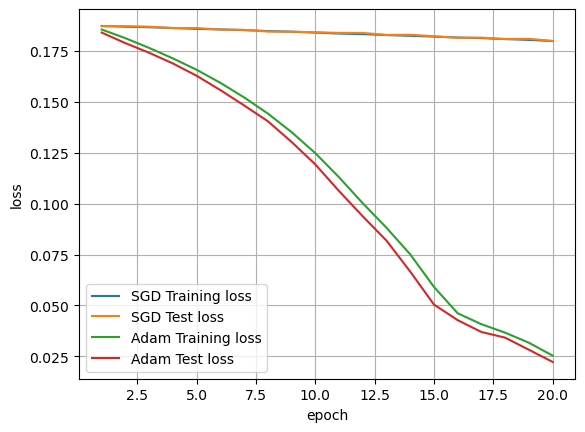

In [2]:
import numpy as np
import matplotlib.pyplot as plt

SGD_train_loss = 'data/example_2_1/exact_train_loss_SGD.npy'
SGD_test_loss = 'data/example_2_1/exact_test_loss_SGD.npy'
Adam_train_loss = 'data/example_2_1/exact_train_loss_Adam.npy'
Adam_test_loss = 'data/example_2_1/exact_test_loss_Adam.npy'


SGD_train_loss = np.load(SGD_train_loss)
SGD_test_loss = np.load(SGD_test_loss)
Adam_train_loss = np.load(Adam_train_loss)
Adam_test_loss = np.load(Adam_test_loss)


x= np.linspace(1,len(SGD_train_loss),len(SGD_train_loss))

plt.plot(x, SGD_train_loss, label= 'SGD Training loss', linestyle='-',)
plt.plot(x, SGD_test_loss,label='SGD Test loss', linestyle='-')
plt.plot(x, Adam_train_loss, label= 'Adam Training loss', linestyle='-',)
plt.plot(x, Adam_test_loss,label='Adam Test loss', linestyle='-')

plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.grid(True)
plt.savefig('example_2_1_loss.png')
plt.show()

## Additional checks
not in the thesis

### Gradcheck
computes numerical gradients and compares it to the gradient from the adjoint method and plots it along min and max cell diameters of the mesh. not really conclusive with the diameters only but it serves a s a check that the adjoint method is correctly implemented.

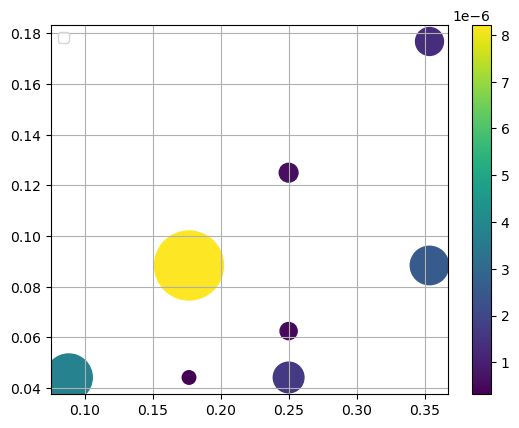

In [6]:
import torch
import numpy as np
import matplotlib.pyplot as plt



input = test_dataset[0]['x']
eps = 1e-4
nn = model(device=input.device, dtype=input.dtype, dir='data/example_2_1/models/nn_init.pth')

grad_err = []
up = []
low = []
for j in range(10):
    func = test_dataset[j]['fem_solver']
    input = test_dataset[j]['x']
    out = nn(input)
    x = out.clone().detach()
    x.requires_grad = True
    num_grad = torch.zeros(len(x))
    for i in range(x.numel()):
        x_pos = x.clone().detach()
        x_neg = x.clone().detach()

        x_pos[i] += eps
        x_neg[i] -= eps

        num_grad[i] = (func(x_pos) - func(x_neg)) / (2 * eps)


    x.grad = None
    func(x).backward()

    max_len = 0
    for i in range(input.shape[1]):
        cell = input[:6,i]
        a = torch.sqrt(cell[0]**2 + cell[1]**2)
        if a > max_len:
            max_len = a.item()
        b= torch.sqrt(cell[2]**2 + cell[3]**2)
        if b > max_len:
            max_len = b.item()
        c = torch.sqrt(cell[4]**2 + cell[5]**2)
        if c > max_len:
            max_len = c.item()
    min_len = 1
    for i in range(input.shape[1]):
        cell = input[:6,i]
        cell_diam = 0
        a = torch.sqrt(cell[0]**2 + cell[1]**2)
        if a > cell_diam:
            cell_diam = a.item()
        b= torch.sqrt(cell[2]**2 + cell[3]**2)
        if b > cell_diam:
            cell_diam = b.item()
        c = torch.sqrt(cell[4]**2 + cell[5]**2)
        if c > cell_diam:
            cell_diam = c.item()
        if cell_diam < min_len:
            min_len = cell_diam
    grad_err.append(torch.max(torch.abs(x.grad - num_grad)).item())
    low.append(min_len)
    up.append(max_len)

low = np.array(low)
up = np.array(up)
grad_err = np.array(grad_err)
arr = np.vstack((low, up, grad_err))

grad_loss_file = 'data/example_2_1/grad_loss_1e4.npy'
np.save(file=grad_loss_file, arr=arr)


grad_diff = 'data/example_2_1/grad_loss_1e4.npy'


grad_diff = np.load(grad_diff)



plt.scatter(x=grad_diff[1], y=grad_diff[0], sizes=3*1e+8*grad_diff[2], c=grad_diff[2], cmap='viridis')


plt.colorbar()
plt.grid(True)
plt.legend()
plt.savefig('section_2_3_1_grad_diff.png')
plt.show()

## supervised dataset (target values)


```Python
from IPython.display import clear_output
from dolfinx import io, fem, mesh as msh, default_scalar_type
import ufl
import torch
import os
from mpi4py import MPI
import numpy as np
from utils.FEniCSx_solver import FEniCSx_solver
from utils.FEniCSx_PyTorch_interface import FEniCSx_PyTorch_interface

model_init='data/example_2_1/models/nn_init.pth'

nn= model(device='cpu', dtype=torch.float64, dir=model_init)
w = nn.state_dict()['w'].detach().numpy()


data = [["data/example_2_1/test_set/fem_data/", 'data/example_2_1/test_set/target_values/t'], ["data/example_2_1/training_set/fem_data/", 'data/example_2_1/training_set/target_values/t']]
iterations = 500
for [mesh_dir, dir] in data:
    train_loss = 0
    lst = os.listdir(mesh_dir)
    size = len([f for f in lst if f.endswith('.xdmf')])
    for idx in range(size):
        mesh_path = os.path.join(mesh_dir, f"mesh_{idx}.xdmf")
        with io.XDMFFile(MPI.COMM_WORLD, mesh_path, "r") as reader:
            mesh = reader.read_mesh()


        Wh = fem.functionspace(mesh, ('P', 2))
        mesh.topology.create_connectivity(mesh.topology.dim - 1, mesh.topology.dim)
        boundary_facets = msh.exterior_facet_indices(mesh.topology)
        boundary_dofs = fem.locate_dofs_topological(Wh, mesh.topology.dim-1, boundary_facets)
        bcs = [fem.dirichletbc(fem.Constant(mesh, default_scalar_type(0.0)), boundary_dofs, Wh)]

        eps = fem.Constant(mesh, default_scalar_type(1e-8))
        b = ufl.as_vector((fem.Constant(mesh, default_scalar_type(1.0)),fem.Constant(mesh, default_scalar_type(0.0))))
        f = fem.Constant(mesh, default_scalar_type(1.0))
        uh = fem.Function(Wh)

        x = ufl.SpatialCoordinate(mesh)
        ex_exp = x[0]*(1-ufl.exp(-(1-x[0])/eps))* (1 - (((ufl.exp(-(1-x[1])/eps)  + ufl.exp(-(x[1])/eps)))- ufl.exp(-(1)/eps))/(1-ufl.exp(-1/eps)))


        exp = fem.Expression(ex_exp, Wh.element.interpolation_points())

        u_ex = fem.Function(Wh)
        u_ex.interpolate(exp)

        loss = (uh-u_ex)**2 * ufl.dx
        pde_data = mesh,Wh,uh,eps,b,None,f,None,bcs

        FEniCSx = FEniCSx_solver(pde_data=pde_data, loss_form=loss)

        lst = []
        bK = np.array([1,0])
        for v in mesh.geometry.x[:,0:2][mesh.geometry.dofmap]:
            xK = np.concat((v[2]-v[1], v[2]-v[0], v[1]-v[0], bK), axis=None)
            lst.append(xK)

        xnp=np.array(lst).T
        z1 = np.matmul(w, xnp)
        Pe = z1/(2*1e-8)
        supg_params = z1/2*(1/np.tanh(Pe)-(2*1e-8)*z1)

        FEniCSx.set_weights(supg_params)
        params = torch.tensor(supg_params, requires_grad=True)
        autograd_func = FEniCSx_PyTorch_interface.apply
        
        def fem_solver(weights):
            return autograd_func(weights, FEniCSx)
        
        optimizer = torch.optim.Adam([params])
        train_loss = 0
        for steps in range(iterations):
            optimizer.zero_grad()
            loss = fem_solver(params)
            loss.backward()
            # Backpropagation
            optimizer.step()

        train_loss += loss
        target = params
        torch.save(target, f'{dir}_{idx}.pt')
        clear_output(wait=True)
        print(f"Current datapoint: {idx} \n")
        print(f"loss: {loss}")
    train_loss /= size
    print(f"train_loss: {train_loss:>7f}")
```

## Supervised datloaders


In [ ]:
import os
from dolfinx import io
from dolfinx import fem
from dolfinx import default_scalar_type
from dolfinx import mesh as msh
import ufl
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from mpi4py import MPI

from utils.FEniCSx_PyTorch_interface import FEniCSx_PyTorch_interface
from utils.FEniCSx_solver import FEniCSx_solver

batch_size = 10

class Dataset_example_2_1(Dataset):
    def __init__(self, input_dir, target_dir):
        self.input_dir = input_dir
        self.target_dir = target_dir

    def __len__(self):
        lst = os.listdir(self.input_dir)
        return len([f for f in lst if f.endswith('.pt')])

    def __getitem__(self, idx):
        input_path = os.path.join(self.input_dir, f"x_{idx}.pt")
        input = torch.load(input_path) 

        target_path = os.path.join(self.target_dir, f"t_{idx}.pt")
        target = torch.load(target_path) 

        return {'x':input, 't':target}
    
def collate_fn(batch):
    X = [b['x'] for b in batch]
    T  = [b['t'] for b in batch]
    return X, T

train_dataset = Dataset_example_2_1(input_dir="data/example_2_1/training_set/inputs/", target_dir="data/example_2_1/training_set/target_values")
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)

test_dataset = Dataset_example_2_1(input_dir="data/example_2_1/test_set/inputs/", target_dir="data/example_2_1/test_set/target_values/")
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)

## naive supervised model
training of the model

In [ ]:
import numpy as np
import torch
import torch

from utils.self_supervised_test_loss import test_loop



def train_loop(dataloader, nn, optimizer):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    nn.train()
    train_loss = 0
    loss_fn = torch.nn.MSELoss()
    for batch, (X, T) in enumerate(dataloader):
        agg_loss = 0
        batch_size = len(X)
        for idx in range(batch_size):
        # Compute prediction and loss
            z2 = nn(X[idx])
            t = T[idx]
            loss = loss_fn(z2, t)/batch_size
            loss.backward()
            agg_loss += loss.item()
        # Backpropagation
        optimizer.step()
        optimizer.zero_grad()

        if batch % 10 == 0:
            loss, current = agg_loss, batch * batch_size
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
        train_loss += agg_loss
    train_loss /= num_batches
    print(f"train_loss: {train_loss:>7f}")
    return(train_loss)




def train(model_dir, model_init, optim, dtype, device, epochs):
    nn = model(device=device, dtype=dtype, dir=model_init)
    optimizer = optim(nn.parameters())
    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        train_loss_arrray = np.append(train_loss_arrray, train_loop(train_loader, nn, optimizer))
        torch.save(nn.state_dict(), f'{model_dir}_{t}.pth')


def test(model_nm, epochs, dtype, device, test_loss_file):
    test_loss_arrray = np.array([])
    for idx in range(epochs):
        nn = model(device=device, dtype=dtype, dir=f"{model_nm}_{idx}.pth")
        print(f"Epoch {idx+1}\n-------------------------------")
        test_loss_arrray = np.append(test_loss_arrray,test_loop(test_loader,  nn))

    np.save(file=test_loss_file, arr=test_loss_arrray)

input = train_dataset[0]['x']


train(
         model_dir='data/section_2_3_2/models/nn_supervised_Adam',
         model_init='data/example_2_1/models/nn_init.pth',
         optim=torch.optim.Adam,
         dtype=input.dtype,
         device=input.device,
         epochs=20,
         )
#compute the train loss
test(
        model_nm='data/section_2_3_2/models/nn_supervised_Adam',
        epochs=20,
        dtype=input.dtype,
        device=input.device,
        test_loss_file='data/section_2_3_2/supervised_train_loss_Adam.npy'
        )
#compute the test loss
test(
        model_nm='data/section_2_3_2/models/nn_supervised_Adam',
        epochs=20,
        dtype=input.dtype,
        device=input.device,
        test_loss_file='data/section_2_3_2/supervised_test_loss_Adam.npy'
        )

print("Done!")

## Comparison of the time to train the models

In [7]:
import time
from dolfinx import io, fem, mesh as msh, default_scalar_type
import ufl
import torch
import os
from mpi4py import MPI
import numpy as np
from utils.FEniCSx_solver import FEniCSx_solver
from utils.FEniCSx_PyTorch_interface import FEniCSx_PyTorch_interface

def train_loop(dataloader, nn, optimizer):
    nn.train()
    train_loss = 0
    for batch, (X, fem_solver) in enumerate(dataloader):
        agg_loss = 0
        batch_size = len(X)
        for idx in range(batch_size):
        # Compute prediction and loss
            z2 = nn(X[idx])
            loss = 1/batch_size*fem_solver[idx](z2)
            loss.backward()
            agg_loss += loss.item()
        # Backpropagation
        optimizer.step()
        optimizer.zero_grad()

    return(train_loss)



start = time.perf_counter()
input = test_dataset[0]['x']
nn=model(dtype=input.dtype, device=input.device, dir='data/example_2_1/models/nn_init.pth')
optimizer = torch.optim.Adam(nn.parameters())

for i in range(20):
    train_loop(dataloader=test_loader, nn=nn, optimizer=optimizer)
t1 = (time.perf_counter() - start)
disp1 = f"example 2.1 model training on test set takes {t1:.3f} seconds"
print(disp1)



start = time.perf_counter()

dataset = test_dataset
iterations = 20


model_init='data/example_2_1/models/nn_init.pth'

nn= model(device='cpu', dtype=torch.float64, dir=model_init)
w = nn.state_dict()['w'].detach().numpy()

size = len(dataset)
mesh_dir = "data/example_2_1/test_set/fem_data/"
iterations = 20
lst = os.listdir(mesh_dir)
size = len([f for f in lst if f.endswith('.xdmf')])
for idx in range(size):
    mesh_path = os.path.join(mesh_dir, f"mesh_{idx}.xdmf")
    with io.XDMFFile(MPI.COMM_WORLD, mesh_path, "r") as reader:
        mesh = reader.read_mesh()


    Wh = fem.functionspace(mesh, ('P', 2))
    mesh.topology.create_connectivity(mesh.topology.dim - 1, mesh.topology.dim)
    boundary_facets = msh.exterior_facet_indices(mesh.topology)
    boundary_dofs = fem.locate_dofs_topological(Wh, mesh.topology.dim-1, boundary_facets)
    bcs = [fem.dirichletbc(fem.Constant(mesh, default_scalar_type(0.0)), boundary_dofs, Wh)]

    eps = fem.Constant(mesh, default_scalar_type(1e-8))
    b = ufl.as_vector((fem.Constant(mesh, default_scalar_type(1.0)),fem.Constant(mesh, default_scalar_type(0.0))))
    f = fem.Constant(mesh, default_scalar_type(1.0))
    uh = fem.Function(Wh)

    x = ufl.SpatialCoordinate(mesh)
    ex_exp = x[0]*(1-ufl.exp(-(1-x[0])/eps))* (1 - (((ufl.exp(-(1-x[1])/eps)  + ufl.exp(-(x[1])/eps)))- ufl.exp(-(1)/eps))/(1-ufl.exp(-1/eps)))


    exp = fem.Expression(ex_exp, Wh.element.interpolation_points())

    u_ex = fem.Function(Wh)
    u_ex.interpolate(exp)

    loss = (uh-u_ex)**2 * ufl.dx
    pde_data = mesh,Wh,uh,eps,b,None,f,None,bcs

    FEniCSx = FEniCSx_solver(pde_data=pde_data, loss_form=loss)

    lst = []
    bK = np.array([1,0])
    for v in mesh.geometry.x[:,0:2][mesh.geometry.dofmap]:
        xK = np.concat((v[2]-v[1], v[2]-v[0], v[1]-v[0], bK), axis=None)
        lst.append(xK)

    xnp=np.array(lst).T
    z1 = np.matmul(w, xnp)
    Pe = z1/(2*1e-8)
    supg_params = z1/2*(1/np.tanh(Pe)-(2*1e-8)*z1)

    FEniCSx.set_weights(supg_params)
    params = torch.tensor(supg_params, requires_grad=True)
    autograd_func = FEniCSx_PyTorch_interface.apply
    
    def fem_solver(weights):
        return autograd_func(weights, FEniCSx)
    
    optimizer = torch.optim.Adam([params])
    train_loss = 0
    for steps in range(iterations):
        optimizer.zero_grad()
        loss = fem_solver(params)
        loss.backward()
        # Backpropagation
        optimizer.step()
t2 = time.perf_counter() - start
disp2 = f"Section 2.3.1: performing 20 Adam steps for each mesh in the training set takes {t2:.3f} seconds"
print(disp2)

disp3 = f"Section 2.3.1: Computing 20*size_dataset gradients in one epoch can be done in 1/{int(t1/t2)} of the time it takes to compute size_dataset gradients in 20 epochs."
print(disp3)

example 2.1 model training on test set takes 216.239 seconds
Section 2.3.1: performing 20 Adam steps for each mesh in the training set takes 34.728 seconds
Section 2.3.1: Computing 20*size_dataset gradients in one epoch can be done in 1/6 of the time it takes to compute size_dataset gradients in 20 epochs.


## Comparison of the loss values for the self supervised and supervised approach

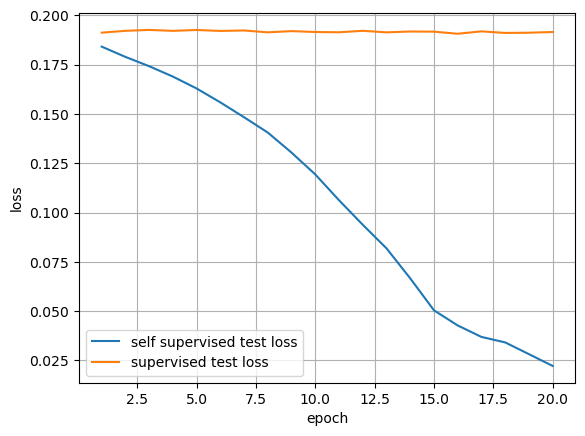

In [5]:
import numpy as np
import matplotlib.pyplot as plt

Adam_test_loss = 'data/example_2_1/exact_test_loss_Adam.npy'
supervised_test_loss = 'data/section_2_3_2/supervised_test_loss_Adam.npy'


Adam_test_loss = np.load(Adam_test_loss)
supervised_test_loss = np.load(supervised_test_loss)


x= np.linspace(1,len(Adam_test_loss),len(Adam_test_loss))

plt.plot(x, Adam_test_loss, label= 'self supervised test loss', linestyle='-',)
plt.plot(x, supervised_test_loss,label='supervised test loss', linestyle='-')

plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.grid(True)
plt.savefig('section_2_3_2_loss.png')
plt.show()

## Comparison of the paramters computed by direct optimization and the naive model

In [8]:
from dolfinx import io, fem, mesh as msh, plot, default_scalar_type
import ufl
from mpi4py import MPI
import pyvista as pv
import os

import torch

from utils.FEniCSx_solver import FEniCSx_solver


def plot_params(mesh, params):
    Wh = fem.functionspace(mesh, ('P', 2))
    mesh.topology.create_connectivity(mesh.topology.dim - 1, mesh.topology.dim)
    boundary_facets = msh.exterior_facet_indices(mesh.topology)
    boundary_dofs = fem.locate_dofs_topological(Wh, mesh.topology.dim-1, boundary_facets)
    bcs = [fem.dirichletbc(fem.Constant(mesh, default_scalar_type(0.0)), boundary_dofs, Wh)]

    eps = fem.Constant(mesh, default_scalar_type(1e-8))
    b = ufl.as_vector((fem.Constant(mesh, default_scalar_type(1.0)),fem.Constant(mesh, default_scalar_type(0.0))))
    f = fem.Constant(mesh, default_scalar_type(1.0))
    uh = fem.Function(Wh)

    x = ufl.SpatialCoordinate(mesh)
    ex_exp = x[0]*(1-ufl.exp(-(1-x[0])/eps))* (1 - (((ufl.exp(-(1-x[1])/eps)  + ufl.exp(-(x[1])/eps)))- ufl.exp(-(1)/eps))/(1-ufl.exp(-1/eps)))


    exp = fem.Expression(ex_exp, Wh.element.interpolation_points())

    u_ex = fem.Function(Wh)
    u_ex.interpolate(exp)

    loss = (uh-u_ex)**2 * ufl.dx
    pde_data = mesh,Wh,uh,eps,b,None,f,None,bcs




    c_topology, c_cell_types, c_geometry = plot.vtk_mesh(Wh)

    fs = FEniCSx_solver(pde_data=pde_data, loss_form=loss)

    fs.set_weights(params)
    fem_grid = pv.UnstructuredGrid(c_topology, c_cell_types, c_geometry)
    fem_grid.cell_data[''] = fs.yh.x.array
    fem_grid.cell_data_to_point_data()
    return fem_grid


idx = 3

target = torch.load(f'data/example_2_1/training_set/target_values/t_{idx}.pt').detach().numpy()
input = torch.load(f'data/example_2_1/training_set/inputs/x_{idx}.pt')

with io.XDMFFile(MPI.COMM_WORLD, f'data/example_2_1/training_set/fem_data/mesh_{idx}.xdmf', "r") as reader:
    mesh = reader.read_mesh()

nn = model(device=input.device, dtype=input.dtype, dir='data/example_2_1/models/nn_exact_Adam_19.pth')

pred = nn(input).detach().numpy()





p = pv.Plotter(shape=(1,2))

p.subplot(0,0)
p.add_mesh(plot_params(mesh, target), show_edges=False, scalar_bar_args={"vertical":False}, clim=(0,1))

p.camera_position = 'xy'
p.zoom_camera(1.5)
p.show_axes()
p.add_text('Individually optimized')

p.subplot(0,1)
p.add_mesh(plot_params(mesh, pred), show_edges=False)

p.camera_position = 'xy'
p.zoom_camera(1.5)
p.show_axes()
p.add_text('Model output')


p.show()

Widget(value='<iframe src="http://localhost:49831/index.html?ui=P_0x330eb9a90_2&reconnect=auto" class="pyvista…

## Comparison of the models implemented so far

Test Error: 0.006146 



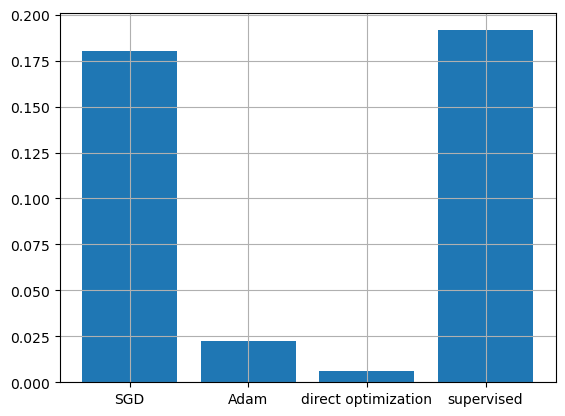

In [7]:
from dolfinx import fem, default_scalar_type, mesh as msh, io
import ufl
from mpi4py import MPI
import torch
from utils.FEniCSx_solver import FEniCSx_solver
from utils.FEniCSx_PyTorch_interface import FEniCSx_PyTorch_interface
import os
import numpy as np



SGD_test_loss = 'data/example_2_1/exact_test_loss_SGD.npy'
a0 = np.load(SGD_test_loss)[-1]

Adam_test_loss = 'data/example_2_1/exact_test_loss_Adam.npy'
a1 = np.load(Adam_test_loss)[-1]


size = len(test_dataset)
a2 = 0
mesh_dir="data/example_2_1/test_set/fem_data/"
target_dir="data/example_2_1/test_set/target_values/"

for idx in range(size):
    mesh_path = os.path.join(mesh_dir, f"mesh_{idx}.xdmf")
    with io.XDMFFile(MPI.COMM_WORLD, mesh_path, "r") as reader:
        mesh = reader.read_mesh()


    Wh = fem.functionspace(mesh, ('P', 2))
    mesh.topology.create_connectivity(mesh.topology.dim - 1, mesh.topology.dim)
    boundary_facets = msh.exterior_facet_indices(mesh.topology)
    boundary_dofs = fem.locate_dofs_topological(Wh, mesh.topology.dim-1, boundary_facets)
    bcs = [fem.dirichletbc(fem.Constant(mesh, default_scalar_type(0.0)), boundary_dofs, Wh)]

    eps = fem.Constant(mesh, default_scalar_type(1e-8))
    b = ufl.as_vector((fem.Constant(mesh, default_scalar_type(1.0)),fem.Constant(mesh, default_scalar_type(0.0))))
    f = fem.Constant(mesh, default_scalar_type(1.0))
    uh = fem.Function(Wh)

    x = ufl.SpatialCoordinate(mesh)
    ex_exp = x[0]*(1-ufl.exp(-(1-x[0])/eps))* (1 - ((ufl.exp(-(1-x[1])/eps)  + ufl.exp(-(x[1])/eps))- ufl.exp(-(1)/eps))/(1-ufl.exp(-1/eps)))


    exp = fem.Expression(ex_exp, Wh.element.interpolation_points())

    u_ex = fem.Function(Wh)
    u_ex.interpolate(exp)

    loss = (uh-u_ex)**2 * ufl.dx
    pde_data = mesh,Wh,uh,eps,b,None,f,None,bcs

    FEniCSx = FEniCSx_solver(pde_data=pde_data, loss_form=loss)

    autograd_func = FEniCSx_PyTorch_interface.apply
    
    def fem_solver(weights):
            return autograd_func(weights, FEniCSx)
    
    target_path = os.path.join(target_dir, f"t_{idx}.pt")
    target = torch.load(target_path) 
    with torch.no_grad():
        # Compute prediction and loss
            a2 += fem_solver(target)

a2 /= size
print(f"Test Error: {a2:>8f} \n")

supervised_test_loss = 'data/section_2_3_2/supervised_test_loss_Adam.npy'
a3 = np.load(supervised_test_loss)[-1]

y = np.array([a0,a1,a2,a3])


import matplotlib.pyplot as plt

x = ['SGD', 'Adam', 'direct optimization', 'supervised']

plt.bar(x,y)
plt.grid()
plt.savefig('section_2_3_2_model_compare.png')
plt.show()
